In [28]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import pi as π

import perceval as pv
from scipy.optimize import minimize
from perceval.components import *

from collections import Counter

from submission.circuits import fullCircuit
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Fraction of [1, 0, x, y] states
def getFidelityRho1(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[0] == 1 and state[1] == 0:
            validCounts += counts[state]

    return validCounts/totCounts


# Fraction of [x, y, 1, 0] states
def getFidelityRho2(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[2] == 1 and state[3] == 0:
            validCounts += counts[state]

    return validCounts/totCounts

def getFidelities(counts):
    return (getFidelityRho1(counts), getFidelityRho2(counts))

def costFunctionAtPhi(counts):
    return (1 - getFidelityRho1(counts))**2 + (1 - getFidelityRho2(counts))**2 + (getFidelityRho1(counts)-getFidelityRho2(counts))**2

In [ ]:
def computeFidelity(x0, testPhi = π/2):

    circuit = fullCircuit(evolTheta=x0, prepTheta=π/2, prepPhi=testPhi)

    p = pv.Processor("SLOS", circuit)
    p.with_input(pv.BasicState([0, 1, 0, 1]))

    # The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
    sampler = pv.algorithm.Sampler(p)  
    sample_count = sampler.sample_count(1000)['results']
    
    valid_counts = {}
    for c in sample_count:
        if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
            valid_counts[c] = sample_count[c]

    print(valid_counts)
    fr1 = getFidelityRho1(valid_counts)
    fr2 = getFidelityRho2(valid_counts)

    print(fr1)
    print(fr2)

    return fr1, fr2

In [ ]:
def loss_function(theta = [0] * 12):
    cost = 0
    Phi = [ 0, π/2, π, 3*π/2 ]

    # Evaluate the 4 cost functions, one for each fidelity
    for phi_i in Phi:
        circuit = fullCircuit(evolTheta=theta, prepTheta=π/2, prepPhi=phi_i)
        p = pv.Processor("SLOS", circuit)
        p.with_input(pv.BasicState([0, 1, 0, 1]))

        # The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
        sampler = pv.algorithm.Sampler(p)  
        sample_count = sampler.sample_count(1000)['results']

        valid_counts = {}
        for c in sample_count:
            if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
                valid_counts[c] = sample_count[c]
        
        cost += costFunctionAtPhi(valid_counts)
        
    return cost

In [ ]:
def optimCallback(intermediate_result):
    
    outLine = f'{intermediate_result.fun:0.3f}, '
    for x in intermediate_result.x:
        outLine += f'{x}, '
    outLine += '\n'

    print(outLine)
    with open('ResultFile.csv', 'a+') as outFile:
        outFile.writelines([outLine])

In [ ]:
class ao():
    def __init__(self, x0):
        self.x = x0

def minimizeVal(swapMimimizers = 3, x0 = None):
    res = ao((np.random.rand(1, 12)[0])*2*π) if x0 == None else ao(x0)

    print(res.x)

    with open('ResultFile.csv', 'w') as outFile:
        outFile.writelines('Fun, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11')

    for minimizerSwapIndex in range(swapMimimizers):
        res = minimize(loss_function,
            res.x,
            method="Nelder-Mead",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback,
            options={'maxiter':100}
        )
        optimCallback(res)


        res = minimize(loss_function,
            res.x,
            method="powell",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback
        )
        optimCallback(res)


    return res

In [ ]:
res = minimizeVal(10)

[0.5164117  5.39212866 1.92545967 3.09979504 5.25650101 0.45589054
 0.76236297 5.09307781 1.48002671 4.56858568 1.19689146 3.86881603]
3.288, 0.516411697795862, 5.392128662658481, 1.925459674932831, 3.0997950415834596, 5.256501008103282, 0.4558905367658528, 0.762362966394904, 5.093077808147028, 1.4800267101890516, 4.5685856760688885, 1.1968914569903275, 4.062256834239908, 

3.288, 0.516411697795862, 5.392128662658481, 1.925459674932831, 3.0997950415834596, 5.256501008103282, 0.4558905367658528, 0.762362966394904, 5.093077808147028, 1.4800267101890516, 4.5685856760688885, 1.1968914569903275, 4.062256834239908, 

2.927, 0.5112117188944449, 5.483869740599541, 1.9582192319021745, 3.1525346099992895, 4.754578168787869, 0.4636470077038828, 0.7753337251981505, 5.179730868077311, 1.5052077201887952, 4.646315085140898, 1.217255235251621, 3.9346396387198075, 

2.927, 0.5112117188944449, 5.483869740599541, 1.9582192319021745, 3.1525346099992895, 4.754578168787869, 0.4636470077038828, 0.7753337251

In [ ]:
computeFidelity(res.x)

{|1,0,1,0>: 199, |1,0,0,1>: 53, |0,1,1,0>: 35, |0,1,0,1>: 31}
0.7924528301886793
0.7358490566037735


(0.7924528301886793, 0.7358490566037735)

{|1,0,1,0>: 188, |1,0,0,1>: 52, |0,1,1,0>: 36, |0,1,0,1>: 34}
0.7741935483870968
0.7225806451612903
{|1,0,1,0>: 222, |1,0,0,1>: 45, |0,1,1,0>: 27, |0,1,0,1>: 45}
0.7876106194690266
0.7345132743362832
{|1,0,1,0>: 200, |1,0,0,1>: 50, |0,1,1,0>: 28, |0,1,0,1>: 45}
0.7739938080495357
0.7058823529411765
{|1,0,1,0>: 211, |1,0,0,1>: 55, |0,1,1,0>: 36, |0,1,0,1>: 34}
0.7916666666666666
0.7351190476190477
{|1,0,1,0>: 190, |1,0,0,1>: 59, |0,1,1,0>: 24, |0,1,0,1>: 48}
0.7757009345794392
0.6666666666666666
{|1,0,1,0>: 187, |1,0,0,1>: 41, |0,1,1,0>: 34, |0,1,0,1>: 38}
0.76
0.7366666666666667
{|1,0,1,0>: 210, |1,0,0,1>: 44, |0,1,1,0>: 32, |0,1,0,1>: 34}
0.79375
0.75625
{|1,0,1,0>: 209, |1,0,0,1>: 50, |0,1,1,0>: 31, |0,1,0,1>: 41}
0.7824773413897281
0.7250755287009063
{|1,0,1,0>: 192, |1,0,0,1>: 62, |0,1,1,0>: 28, |0,1,0,1>: 32}
0.8089171974522293
0.7006369426751592
{|1,0,1,0>: 220, |1,0,0,1>: 43, |0,1,1,0>: 29, |0,1,0,1>: 34}
0.8067484662576687
0.7638036809815951
{|1,0,1,0>: 206, |1,0,0,1>: 47, |0,1

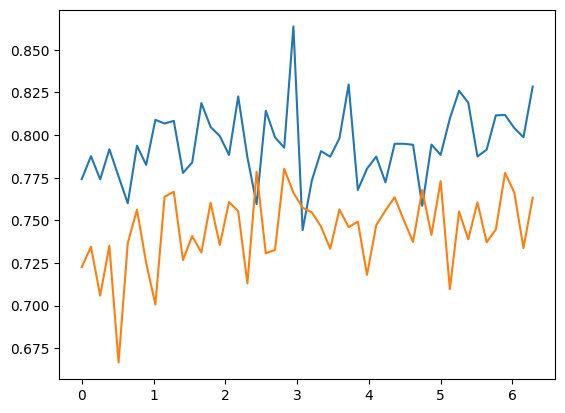

In [ ]:
phi = np.linspace(0, 2*π, 50)
fid = []

for phi_i in phi:
    fid.append(computeFidelity(res.x))

plt.plot(phi, fid)

In [30]:
import csv

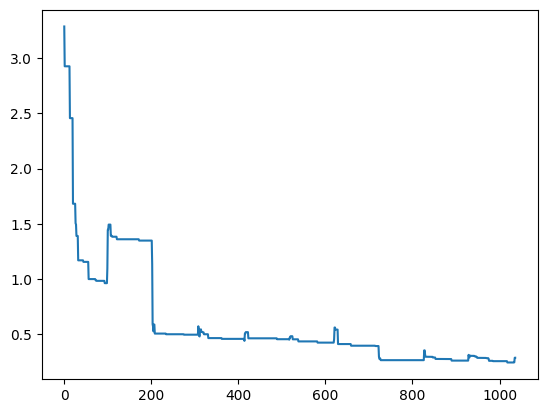

In [40]:
with open('ResultFile.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader)
    costs = []
    for row in spamreader:
        costs.append(float(row[0]))
plt.plot(costs)